In [2]:
import scipy.io
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from os import chdir
chdir('data/Cp_16_05_01')

# I. Importation des données, mise en forme et premiers tests

### 1) Bases de données brutes du GPS et des sensors

In [7]:
# Telechargement des données qui sont sous forme de dictionnaire
exp_ind = 1
gps1 = scipy.io.loadmat('juan{}_gps.mat'.format(exp_ind))
sensors1 = scipy.io.loadmat('juan{}_etc.mat'.format(exp_ind))

In [8]:
# Mise en forme en Data Frame
gps_df = pd.DataFrame(gps1['GPS'], columns = gps1['GPSFieldsOrder'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns = sensors1['ETCFieldsOrder'])

In [9]:
# Changement du nom des variables
gps_df = pd.DataFrame(gps1['GPS'], columns = ['time', 'ts', 'lat', 'long', 'alti', 'course', 'speedOG', 'speedV', 
                                              'SgmLat', 'SgmLong', 'SgmAlti', 'mode', 'sats'])
sensors_df = pd.DataFrame(sensors1['SENSORS'], columns = ['time', 'counts', 'accel', 'steer', 'brake', 'speed'])

### 2) Fonctions utiles au traitement des données brutes

La fonction suivante permet de lire les données 'sensors', on peut ainsi récupérer la vitesse et l'angle des roues :

In [10]:
def readSensorData(sensors_df):
    
    '''Velocity and steering'''
    
    # Sensor parameters
    KV1 = 0.024970 * (1 - 0.21)
    KA1 = 0.00040 * (1 + 0)
    KA0 = 2022
    Kx1 = 1.0127
    Kx2 = 0.0042
    
    time_sensors = sensors_df['time'].values / 1000.
    steering = Kx1 * (sensors_df['steer'].values - KA0) * KA1 + Kx2 
    velocity = KV1 * sensors_df['speed'].values
    
    return time_sensors, steering, velocity

La fonction suivante permet de lire les données GPS afin de récupérer la latitude et la longitude :

In [11]:
def readGPSData(gps_df):
    
    '''Latitude and longtitude'''
    
    # Reference point
    LAT0  = -33.8884
    LONG0 = 151.1948
    
    # GPS parameters
    a =  6378137.0
    b  = a * (1 - 0.003352810664747)
    kpi = np.pi / 180
    cf = np.cos(LAT0 * kpi)
    sf = np.abs(np.sin(LAT0 * kpi))
    Ro = a ** 2 * cf / np.abs(np.sqrt((a *cf) ** 2 + (b * sf) ** 2))  ;
    RR = b / a  * np.abs(np.sqrt(a ** 2- Ro ** 2)) / sf ;
    
    time_gps = gps_df['time'].values / 1000.
    latitude = - RR * kpi * (gps_df['lat'].values + LAT0)
    longtitude = Ro * kpi * (gps_df['long'].values - LONG0)
    
    return time_gps, latitude, longtitude

La fonction suivante nous permet de récupérer trois vecteurs : `time`, `sensor` et `index`. Ces vecteurs nous permettent de savoir de quel capteur nous récupérons une mesure pour chaque temps $t$.

In [12]:
def scanData():
    '''
    Pour avoir le temps, le sensor et l'indice de chaque mesure qui arrive
    Au temps time[i] on a une mesure de sensor[i]
    (1 si gps, 2 si steering et velocity)
    dans l'indice index[i] du tableau correspondant
    '''
    time_sensors, steering, velocity = readSensorData(sensors_df)
    time_gps, latitude, longtitude = readGPSData(gps_df)
    
    times = [(1, i, time) for i, time in enumerate(time_gps)]
    times.extend([(2, i, time) for i, time in enumerate(time_sensors)])

    times = np.array(sorted(times, key = lambda u: u[2]))
    time, sensor, index = times[:, 2], times[:, 0], times[:, 1].astype(int)
    
    return time, sensor, index

### 3) Création des bases de données finales

Nous utilisons les fonctions précédemment introduites afin de créer nos bases de données finales que nous utiliserons par la suite.

In [13]:
GPSData = pd.DataFrame(readGPSData(gps_df), ['times_GPS', 'latitude', 'longitude']).T
SensorData = pd.DataFrame(readSensorData(sensors_df), ['time_sensors', 'steering', 'velocity']).T

Les données GPS contiennent :
- le temps $t$ en première colonne
- la latitude et la longitude en deuxième et troisième colonne

Tandis que les données sensor contiennent :
- le temps $t$ en première colonne
- l'angle des roues (steering) en deuxième colonne
- la vitesse en troisième colonne

In [14]:
GPSData.head()

,times_GPS,latitude,longitude
0,851.227,-5.707890,6.615680
1,851.428,-5.709734,6.615680
2,851.628,-5.702355,6.614138
3,851.828,-5.700510,6.615680
4,852.028,-5.702355,6.615680


In [15]:
SensorData.head()

,time_sensors,steering,velocity
0,851.292,0.064557,0.0
1,851.317,0.064962,0.0
2,851.342,0.064557,0.0
3,851.367,0.064557,0.0
4,851.392,0.064557,0.0


### 4) Quelques visualisations des données finales

Nous représentons ci-après l'évolution de la latitude (en bleu) et de la longitude (en orange) en fonction du temps $t$.

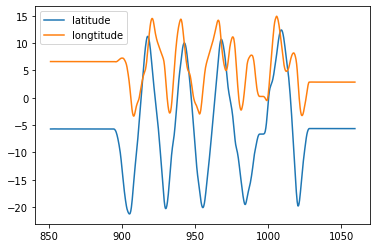

In [17]:
time_gps, latitude, longtitude = readGPSData(gps_df)
plt.plot(time_gps, latitude, label = 'latitude')
plt.plot(time_gps, longtitude, label = 'longtitude')
plt.legend()

Nous représentons ensuite l'évolution de la trajectoire du robot dans l'espace à partir de sa latitude et sa longitude.

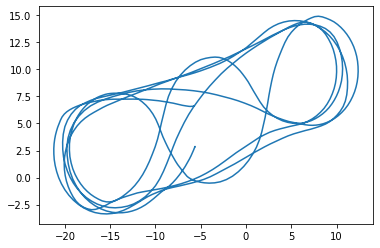

In [18]:
plt.plot(latitude, longtitude)

Nous représentons ci-après l'évolution de l'angle des roues (en bleu) et de la vitesse (en orange) en fonction du temps $t$.

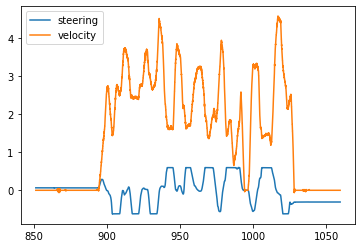

In [19]:
time_sensors, steering, velocity = readSensorData(sensors_df)
plt.plot(time_sensors, steering, label='steering')
plt.plot(time_sensors, velocity, label='velocity')
plt.legend()

# II. Implémentation des fonctions intermédiaires nécessaires

In [20]:
from scipy.stats import dirichlet, multivariate_normal, beta, norm

In [21]:
# Parametres pour le modele de transition (partie bruit)
timestep = (time_sensors[-1] - time_sensors[0]) / (len(time_sensors) - 1)
noise_measures = np.zeros((len(time_sensors) - 2, 2))

# Derivee de la vitesse
noise_measures[:, 0] = (velocity[1:-1] - velocity[:-2]) / timestep

# Derivee seconde de beta
noise_measures[:, 1] = (steering[2:] - 2 * steering[1:-1] + steering[:-2]) / (timestep ** 2)

# Covariance comme esperance
noise_cov = noise_measures.T @ noise_measures / (len(time_sensors) - 2)
noise_mean = np.zeros(2)

In [23]:
var_gps = 0.002
var_sensors = {'beta': 0.002, 'v': 0.1}

p0_z1 = lambda u: 1e-4 # Uniforme sur un grand intervalle
# Etat de "mauvais" fonctionnement du gps

h1 = lambda state: [state['x'], state['y']]

S = var_gps * np.eye(2) # + ?
# Je dirais = 0 parce que le gradient est nul
# puisque x et y ne dependent du noise qu'au 2nd ordre

In [28]:
# Geometric constants
L = 2.83
H = 0.76
a = 3.78
b = 0.5

### 1) Sous-fonctions utiles : calculs de probabilités et générateurs aléatoires

La fonction suivante permet de simuler $\overset{\sim}{\alpha}_{1, t}^{(i)}$ :

In [24]:
def q_alpha(alpha_1_prev, c_t, sigma_t):
    
    ''' === ÉQUATION 26 page 11 ===
    Ici, alpha1 est dans {0, 1}. Par l'article, la loi de Dirichlet est réduite
    à une loi beta. '''
    
    rv = beta(sigma_t * alpha_1_prev + (c == 0))
    
    sampled = rv.rvs()
    proba = rv.pdf(sampled)
    
    return sampled, proba

La fonction suivante permet de simuler $\overset{\sim}{c}_{1, t}^{(i)}$ :

In [25]:
def q_c1(x_pred, S1, alpha1, z1):
    
    ''' === ÉQUATION 29 page 11 === '''
    
    # Probabilite que c_{1, t} = 0 :
    p_c_0 = alpha1 *  p0_z1(z1) / (alpha1 *  p0_z1(z1) 
                                   + (1 - alpha) * multivariate_normal.pdf(z1, h1(x_pred), S1))
    sampled = np.random.binomial(1, p_c_0)
    
    return sampled, p_c_0 if sampled == 0 else 1 - p_c_0

La fonction suivante permet de simuler $\overset{\sim}{\sigma}_{1, t}^{\alpha \ (i)}$ :

In [26]:
# Attention a ca, la densite indiquee dans l'article est bizarre
def q_sigma1(s1, sigma1_new, sigma1, alpha1_new, alpha1):
    
    ''' === ÉQUATION 28 page 11 ===
    La formule est donnée avec un log '''
    
    lambda_a = 1 * np.random.randn(1) # définir la variance de lambda^alpha, c'est un bruit blanc gaussien
    numerateur = np.random.dirichlet(sigma1_new * alpha1) * (lambda_a * np.random.randn(1) + np.log(sigma1))
    denominateur = np.random.dirichlet(sigma1 * alpha1)
    
    return numerateur / denominateur

La fonction suivante permet d'initialiser les états initiaux avec des lois uniformes sur les espaces de vie des variables :

In [27]:
def initilisation_pf(N):
    
    stretch = 1.02
    
    x_min, x_max = np.min(stretch * latitude), np.max(stretch * latitude)
    y_min, y_max = np.min(stretch * longtitude), np.max(stretch * longtitude)
    v_max = np.max(stretch * velocity)
    beta_min, beta_max = np.min(stretch * steering), np.max(stretch * steering)
    beta_dot = (steering[1:] - steering[:-1]) / (time_sensors[1:] - time_sensors[:-1])
    beta_dot_min, beta_dot_max = np.min(stretch * beta_dot), np.max(beta_dot)
    
    init_state = {
        'x': np.random.uniform(low = x_min, high = x_max, size = N),
        'y': np.random.uniform(low = y_min, high = y_max, size = N),
        'v': np.random.uniform(low = 0, high = v_max, size = N),
        'psi': np.random.uniform(low = 0, high = 2*np.pi, size = N),
        'beta': np.random.uniform(low = beta_min, high = beta_max, size = N),
        'beta_dot': np.random.uniform(low = beta_dot_min, high = beta_dot_max, size = N)
    }
    init_gps_state = {
        'sigma': np.exp(np.random.normal(0, 1, size = N)), # c'est un peu arbitraire, si vous avez mieux hesitez pas
        'alpha': np.ones((N, 2)) / (2 * N),
        'c': np.zeros(N), # tous les gps marchent bien a priori
    }
    init_poids = np.ones(N) / N
    
    return init_state, init_gps_state, init_poids

La fonction suivante permet de renvoyer le modèle de transition d'état :

In [112]:
def transition_model(current_state, dt, with_noise = True):
    
    ''' return the state transition model taking into
    account the state noise (v' and beta'') '''
    
    # Retrieve initial states
    x = current_state['x']
    y = current_state['y']
    v = current_state['v']

    psi = current_state['psi']
    beta = current_state['beta']
    beta_dot = current_state['beta_dot']
    
    # Next states
    next_state = dict()
    next_state['x'] = x + dt * v * (np.cos(psi) + (- a * np.sin(psi) + b * np.cos(psi)) * np.tan(beta) / L)
    next_state['y'] = y + dt * v * (np.sin(psi) + (a * np.cos(psi) + b * np.sin(psi)) * np.tan(beta) / L)
    next_state['v'] = v
    
    next_state['psi'] = psi + dt * v * np.tan(beta) / L
    next_state['beta'] = beta + dt * beta_dot
    next_state['beta_dot'] = beta_dot
    
    proba = 1
    if with_noise:
        state_noise = np.random.multivariate_normal(noise_mean, noise_cov, size=x.shape[0])
        next_state['v'] += dt * state_noise[:, 0]
        next_state['beta_dot'] += dt * state_noise[:, 1]

    return next_state

La fonction suivante permet de mettre à jour les poids :

In [113]:
def update_model(N, weights, update_GPS, measures, particles, gps_state): 
    
    # == Cas GPS
    if update_GPS:
        erreur_mesure = np.linalg.norm([particles['x'] - measures['x'], 
                                        particles['y'] - measures['y']], axis = 0)
        c, c_proba = gps_state['c'], gps_state['c_proba']
        
        # mise à jour des poids
        for i in range(N): 
            weights[i] *= c_proba[i] * (
                scipy.stats.norm(0, var_gps).pdf(erreur_mesure[i]) if c[i] == 0 else p0_z1(0)
            )

    # == Cas sensors
    else:
        erreur_mesure_beta = ((particles['beta'] - measures['beta']) + np.pi) % (2 * np.pi) - np.pi
        erreur_mesure_v = particles['v'] - measures['v']     
        
        # mise à jour des poids
        for i in range(N): 
            weights[i] *= (
                scipy.stats.norm(0, var_sensors['v']).pdf(erreur_mesure_v[i])
                * scipy.stats.norm(0, var_sensors['beta']).pdf(erreur_mesure_beta[i])
            )
    
    weights += 1e-300 # Eviter les divisions par 0
    weights /= sum(weights) # normalize  
        
    return weights

La fonction suivante permet de simuler $\overset{\sim}{\alpha}_{1, t}^{(i)}$, $\overset{\sim}{c}_{1, t}^{(i)}$ et $\overset{\sim}{\sigma}_{1, t}^{\alpha \ (i)}$ d'après le modèle graphique :

In [160]:
def update_gps_states(N, gps_states, particles, measures):
    
    # Probabilite que c_{1, t} = 0:
    gps_states_new = dict()
    gps_states_new['c'], gps_states_new['c_proba'] = np.zeros(N), np.zeros(N)
    gps_states_new['alpha'], gps_states_new['alpha_proba'] = np.zeros((N, 2)), np.zeros(N)
    gps_states_new['sigma'], gps_states_new['sigma_proba'] = np.zeros(N), np.zeros(N)
    
    alpha = gps_states['alpha']
    sigma = gps_states['sigma']
    
    for i in range(N):
        
        ''' === ÉQUATION 29 page 11 ===
        Mise à jour de c '''
        
        z1 = [particles['x'][i], particles['y'][i]]
        h_x_1 = [measures['x'], measures['y']]
        
        p_c_0 = alpha[i][0] * p0_z1(z1) / (alpha[i][0] *  p0_z1(z1) 
                                           + alpha[i][1] * multivariate_normal.pdf(z1, h_x_1, S))

        sampled = np.random.binomial(1, p_c_0)

        gps_states_new['c'][i] = sampled
        gps_states_new['c_proba'][i] = p_c_0 if sampled == 0 else 1 - p_c_0
        

    for i in range(N):
        
        ''' === ÉQUATION 26 page 11 ===
        Mise à jour d'alpha '''
        
        params = sigma[i] * alpha[i] + (gps_states_new['c'][i] == 0)
        rv = beta(params[0], params[1])
        try:
            sampled = rv.rvs()
        except:
            print(params, sigma[i], alpha[i])
        proba = rv.pdf(sampled)
        
        gps_states_new['alpha'][i] = (sampled, 1 - sampled)
        gps_states_new['alpha_proba'][i] = proba
        
    rv = norm(0, 1)
    
    for i in range(N):
        
        ''' === ÉQUATION 28 page 11 ===
        Mise à jour de sigma '''
        # !!!! ATTENTION C'EST PAS LA BONNE FORMULE !!!!
        # !!!! TODO: FIX !!!!
        
        sampled = rv.rvs()
        gps_states_new['sigma'][i] = gps_states['sigma'][i] * np.exp(sampled)
        gps_states_new['sigma_proba'][i] = rv.pdf(sampled)

    return gps_states_new

### 2) Filtrage particulaire

In [161]:
def simple_resample(N, particles, gps_states, weights):
    
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, size = N))
    
    # Resample according to indexes
    particles = {key: particles[key][indexes] for key in particles}
    gps_states = {key: gps_states[key][indexes] for key in gps_states}
    weights.fill(1.0 / N)
    
    return particles, gps_states, weights

La fonction suivante renvoie la prédiction de l'état à chaque temps :

In [162]:
def predictions(weights, particles):
    
    tab_predict = [sum(particles['x'] * weights), sum(particles['y'] * weights), 
                   sum(particles['v'] * weights), sum(particles['beta'] * weights)]
    
    return tab_predict

Nous implémentons finalement l'algorithme de filtrage particulaire à l'aide des fonctions précédentes :

In [163]:
def particle_filter(N, skip = 1, verbose = 10, tmax = 1e10):
    
    # === Initialisation === #
    particles, gps_states, weights = initilisation_pf(N)
    t_previous = time[0] / 1000.
    
    # === Itérations === #
    for i in range(min(len(time), tmax)):
        
        if i % verbose == 0:
            print(f'iteration {i // skip} at index {i}')
            
        if i % skip == 0:
            t = time[i] / 1000.
            particles = transition_model(particles, dt = t - t_previous)

            update_GPS = sensor[i] == 1
            
            if update_GPS:
                measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
                gps_states = update_gps_states(N, gps_states, particles, measures)
                
            else:
                measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}

            weights = update_model(N, weights, update_GPS, measures, particles, gps_states)

            # Resampling
            n_eff = 1 / np.sum(weights ** 2)
            if n_eff <= .8 * N:
                print('Resampled')
                particles, gps_states, weights = simple_resample(N, particles, gps_states, weights)
            
            t_previous = t
            list_predict.append(predictions(weights, particles))
            
    return list_predict

### TESTS

In [ ]:
list_predict = list()

time_sensors, steering, velocity = readSensorData(sensors_df)
time_gps, latitude, longtitude = readGPSData(gps_df)
time, sensor, index = scanData()

In [164]:
list_predict = particle_filter(N = 3000, skip = 1, verbose = 10, tmax = 200)

iteration 0 at index 0
Resampled
iteration 10 at index 10
Resampled
iteration 20 at index 20
Resampled
iteration 30 at index 30
Resampled
iteration 40 at index 40
Resampled
iteration 50 at index 50
Resampled
iteration 60 at index 60
Resampled
iteration 70 at index 70
Resampled
Resampled
iteration 80 at index 80
Resampled
iteration 90 at index 90
Resampled
iteration 100 at index 100
Resampled
iteration 110 at index 110
Resampled
iteration 120 at index 120
Resampled
iteration 130 at index 130
Resampled
iteration 140 at index 140
Resampled
iteration 150 at index 150
Resampled
iteration 160 at index 160
Resampled
Resampled
iteration 170 at index 170
Resampled
iteration 180 at index 180
Resampled
iteration 190 at index 190
Resampled


In [165]:
len(list_predict)

200

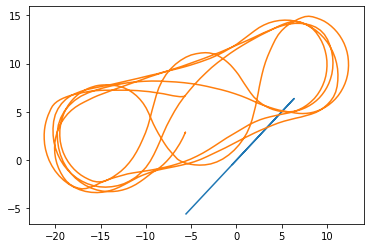

In [166]:
plt.plot(list_predict[:][0], list_predict[:][1])
plt.plot(latitude, longtitude)

# III. Implémentation de l'algorithme 5 : Rao-Blackwell UKF

L'algorithme final est implémenté ci-après :

In [ ]:
def RaoBlackwell_UKF (n_particules, eta = 0.8*n_particules):
    
    # === Initialisation === #
    particles, gps_states, weights = initilisation_pf(N)
    
    # === Itérations === #
    for i in range(len(time)):
        
        t = time[i] / 1000.
        update_GPS = (sensor[i] == 1)
        
        # Si on reçoit une mesure du GPS
        if update_GPS:
            
            # Update de c, alpha et sigma :
            measures = {'x': latitude[index[i]], 'y': longtitude[index[i]]}
            gps_states = update_gps_states(n_particules, gps_states, particles, measures)
            
            # Update de x chapeau et SIGMA avec UKF :
            xchap, SIGMA = UKF(xhap, SIGMA, gps_state['c'], measures) # en cours
            
        # Si on reçoit une mesure du sensor
        else:
            
            measures = {'beta': steering[index[i]], 'v': velocity[index[i]]}
            
            # Update de x chapeau et SIGMA avec UKF :
            xchap, SIGMA = UKF(xhap, SIGMA, measures) 
            
            # Update des variables liées au GPS :
            ''' !!! je comprends ce qu ils veulent qu on mette à jour ici car si on met à jour
            c, alpha et sigma, on fait la meme chose que dans "if update_GPS:" !!! '''
            # Les variables c, alpha et sigma ne sont pas censées changer.
            
        # Update des poids :
        weights = update_model(n_particules, weights, update_GPS, measures, particles, gps_states)
        
        # Resampling :
        Neff = 1 ./ sum(weights ** 2)
        if (Neff <= eta) :
            print('Resampled')
            particles, gps_states, weights = simple_resample(n_particules, particles, gps_states, weights)
        
        t_previous = t
        list_predict.append(predictions(weights, particles))
            
    return list_predict

# IV. Tests des algorithmes

### 1) Filtrage particulaire

### 2) Rao-Blackwell UKF

# A faire (pour avoir l'algo pf et l'algo rao-blackwell):
1 - Sampler le state vector $\tilde{x}_t^{(i)}$ (prendre en compte le state noise), le sensor state variable $\tilde{c}_t^{(i)}$ et les autres pour les particules

2 - Utiliser $\tilde{c}_t^{(i)}$  pour la modelisation du gps

3 - Bien choisir l'importance probability $q$ pour l'algo standard

3 - Trouver la proba cheloue de l'algo Rao-blackwell $p(z_{k,t}|\textbf{z}_{1:t-1})$

4 - Implementer (ou trouver une implementation) de l'UKF

5 - Revoir les distributions initiales $p_0$ (en regardant les histogrammes des mesures par ex)

